# Report for data challenge 4: Computational Urban Data Analytics
From shan yang  duke university

## Data visualization of the RoadNetwork

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import os
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
font = {'family' : 'Times','weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)

In [2]:
chicago = gpd.read_file('/Users/shanyang/Downloads/ORNL-ML/Upload/Road Network/RoadNetwork.geojson')
chicago.head()

,LINKID,FROM,TO,FCC,SPEED,MILES,LANES,DIRECT,geometry
0,0,0,1,A50,None,None,None,0,"LINESTRING (-87.62436 41.87701, -87.62451 41.8..."
1,1,1,2,A50,None,None,None,0,"LINESTRING (-87.62451 41.87700, -87.62523 41.8..."
2,2,2,3,A50,None,None,None,0,"LINESTRING (-87.62523 41.87698, -87.62605 41.8..."
3,3,3,4,A50,None,None,None,0,"LINESTRING (-87.62605 41.87695, -87.62634 41.8..."
4,4,4,5,A50,None,None,None,0,"LINESTRING (-87.62634 41.87696, -87.62654 41.8..."


Text(23.293957326586963, 0.5, 'Latitude')

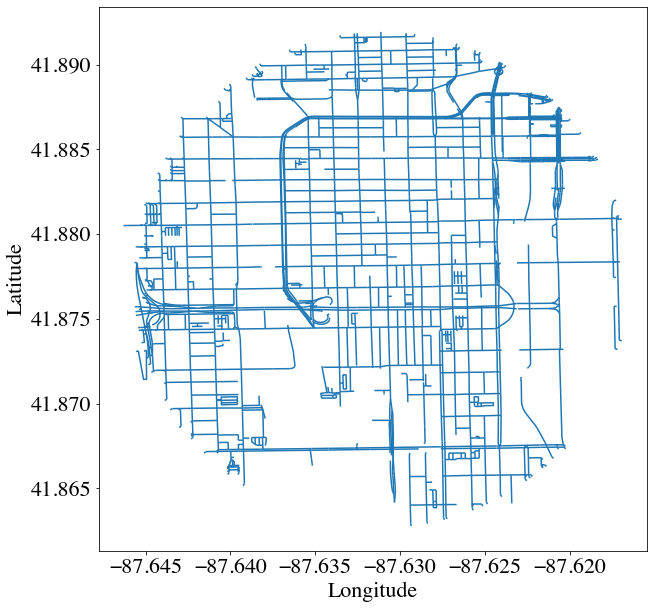

In [3]:
fig,ax = plt.subplots(figsize=(10,10))
ax=chicago.plot(ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [4]:
# change the name of the colume to be consistant with traffic volume data
chicago['linkID'] = chicago['LINKID'].astype(int)
chicago=chicago.drop(columns=['LINKID','SPEED','MILES','LANES','DIRECT'])
chicago.head()

,FROM,TO,FCC,geometry,linkID
0,0,1,A50,"LINESTRING (-87.62436 41.87701, -87.62451 41.8...",0
1,1,2,A50,"LINESTRING (-87.62451 41.87700, -87.62523 41.8...",1
2,2,3,A50,"LINESTRING (-87.62523 41.87698, -87.62605 41.8...",2
3,3,4,A50,"LINESTRING (-87.62605 41.87695, -87.62634 41.8...",3
4,4,5,A50,"LINESTRING (-87.62634 41.87696, -87.62654 41.8...",4


In [5]:
def load_chicago(path):
    path = os.path.join(path,'RoadNetwork.geojson')
    chicago = gpd.read_file(path)
    chicago['linkID'] = chicago['LINKID'].astype(int)
    chicago=chicago.drop(columns=['LINKID','SPEED','MILES','LANES','DIRECT'])
    return chicago

In [6]:
chicago = load_chicago('/Users/shanyang/Downloads/ORNL-ML/Upload/Road Network')
chicago.head()

,FROM,TO,FCC,geometry,linkID
0,0,1,A50,"LINESTRING (-87.62436 41.87701, -87.62451 41.8...",0
1,1,2,A50,"LINESTRING (-87.62451 41.87700, -87.62523 41.8...",1
2,2,3,A50,"LINESTRING (-87.62523 41.87698, -87.62605 41.8...",2
3,3,4,A50,"LINESTRING (-87.62605 41.87695, -87.62634 41.8...",3
4,4,5,A50,"LINESTRING (-87.62634 41.87696, -87.62654 41.8...",4


Text(23.293957326586963, 0.5, 'Latitude')

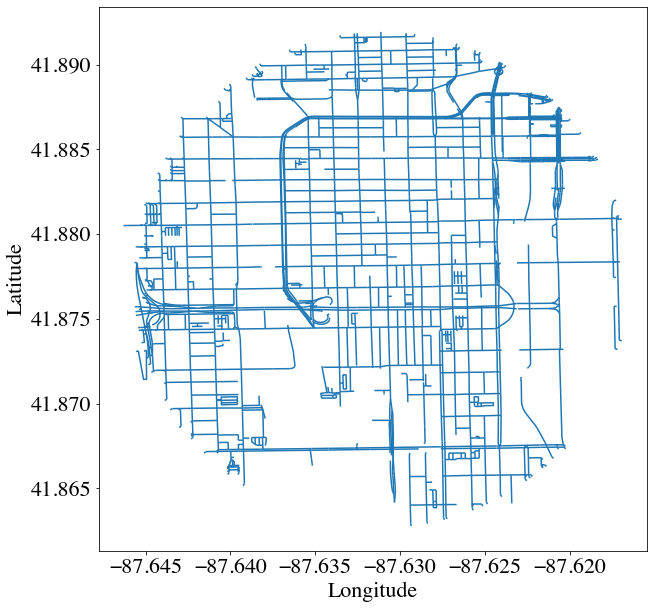

In [7]:
fig,ax = plt.subplots(figsize=(10,10))
ax=chicago.plot(ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

## Preprocess linkVolume data from Monday to Friday
The linkVolume data in traffic volumes folder contain traffic volume for 23 set of weekdays. Due to the data linkVolme are sparse in CSV files, thus caluculate the average linkVolume as well as linkAvgSpeed for every weekdays. 
In addition, in order to show the positions where the high lineVolume and linkAvgSpeed exist, the average lineVolume data and linkAvgSpeed are plotted as colormap on the RoadNetwork.

In [8]:
class Weekdays(Enum):
    Mon = 0;
    Tue = 1;
    Wed = 2;
    Thu = 3;
    Fri = 4;

In [9]:
def load_dir(base_path):
    days_path=[[],[],[],[],[]]
    for file in os.listdir(base_path):
        if file.startswith(Weekdays.Mon.name):
            days_path[Weekdays.Mon.value].append(file)
        elif file.startswith(Weekdays.Tue.name):
            days_path[Weekdays.Tue.value].append(file)
        elif file.startswith(Weekdays.Wed.name):
            days_path[Weekdays.Wed.value].append(file)
        elif file.startswith(Weekdays.Thu.name):
            days_path[Weekdays.Thu.value].append(file)
        elif file.startswith(Weekdays.Fri.name):
            days_path[Weekdays.Fri.value].append(file)
    return days_path

In [10]:
days_path = load_dir('/Users/shanyang/Downloads/ORNL-ML/Upload/Emissions Data/Traffic Volumes/Link Volumes')

In [13]:
def weekday_conjection(days_path,day,bath_path):
    #days_path = load_dir('/Users/shanyang/Downloads/ORNL-ML/Upload/Emissions Data/Traffic Volumes/Link Volumes')
    #base_path = '/Users/shanyang/Downloads/ORNL-ML/Upload/Emissions Data/Traffic Volumes/Link Volumes'
    chicago = load_chicago('/Users/shanyang/Downloads/ORNL-ML/Upload/Road Network')
    #day = Weekdays.Mon;
    volume = pd.DataFrame();
    volume = pd.concat([volume,chicago],axis=0)
    volume['linkLength'] = 0;
    volume['linkVolume'] = 0;
    volume['linkAvgSpeed'] = 0;

    for file in days_path[day.value]:
        path = os.path.join(base_path,file)
        df = pd.read_csv(path, usecols = ['linkID','linkLength','linkVolume','linkAvgSpeed'])
        volume['linkLength'] = df['linkLength']
        volume['linkVolume'] = volume['linkVolume']+df['linkVolume']
        volume['linkAvgSpeed'] = volume['linkAvgSpeed']+df['linkAvgSpeed']
    
    volume['linkVolume'] = volume['linkVolume']/len(days_path[day.value])
    volume['linkAvgSpeed'] = volume['linkAvgSpeed']/len(days_path[day.value])
    chicago=chicago.join(volume.set_index('linkID'), rsuffix = '_'+file, how = 'left',on='linkID')
    
    fig,ax = plt.subplots(figsize = (10,10))
    ax = chicago.plot(   column = 'linkVolume',
                         cmap = 'OrRd',
                         legend = True,
                         legend_kwds={'label':'linkVolume','orientation': 'horizontal'},
                         ax = ax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f"linkVolume {day}")
    
    fig,ax = plt.subplots(figsize = (10,10))
    ax = chicago.plot(   column = 'linkAvgSpeed',
                         cmap = 'OrRd',
                         legend = True,
                         legend_kwds={'label':'linkAvgSpeed','orientation': 'horizontal'},
                         ax = ax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f"linkAvgSpeed {day}")
    return chicago

## linkVolume and linkAvgSpeed for Monday to Friday
From the linkVolume and linkSpeed data, the links where the linkVolumes are high are not the places where the average speed are low. The links with high speed are more distributated then the data of link volume. The links, when the link volume are high, do no variate from Monday to Friday.

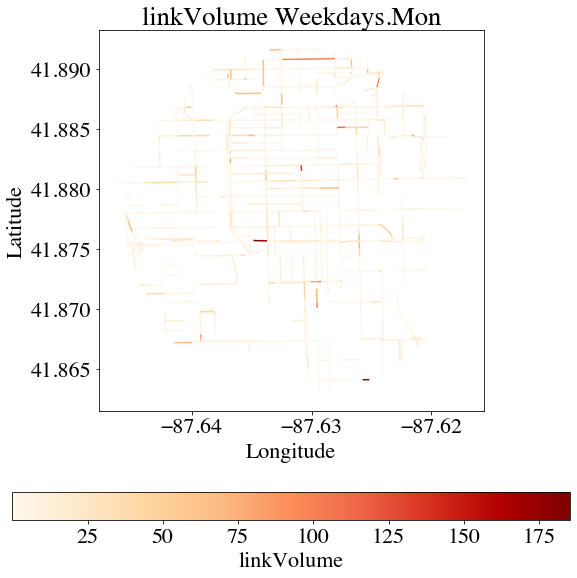

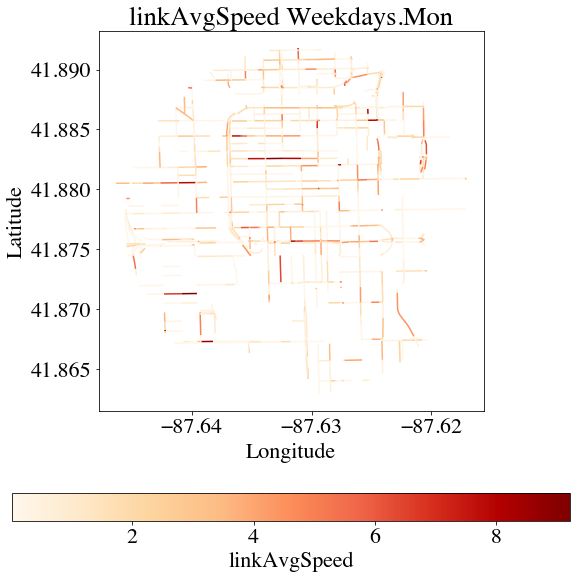

In [14]:
base_path = '/Users/shanyang/Downloads/ORNL-ML/Upload/Emissions Data/Traffic Volumes/Link Volumes'
Mon = weekday_conjection(days_path,Weekdays.Mon,base_path)

In [15]:
# save check point 
Mon.to_csv('TrafficVolumeMon.csv',index = False)

In [16]:
Mon.describe()

,linkID,linkLength,linkVolume,linkAvgSpeed
count,2615.000000,1161.000000,1161.000000,1161.000000
mean,1307.000000,0.041153,10.473407,1.461235
std,755.029801,0.034201,19.469332,1.701523
min,0.000000,0.000005,0.041667,0.020833
25%,653.500000,0.010738,1.000000,0.186417
50%,1307.000000,0.035661,2.708333,0.785000
75%,1960.500000,0.064343,10.458333,2.215286
max,2614.000000,0.233220,185.375000,9.225834


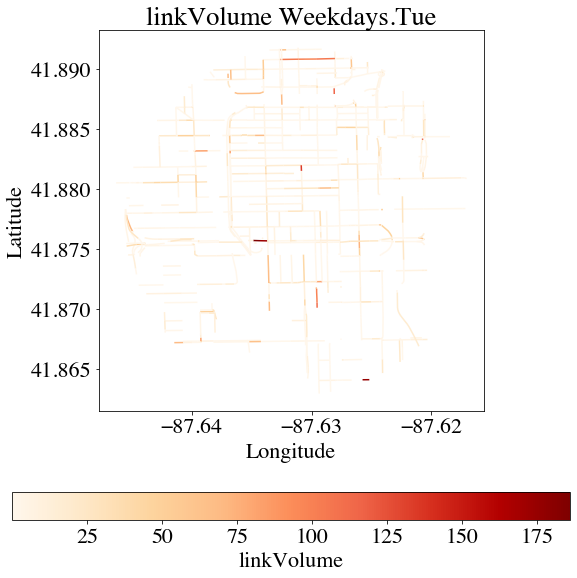

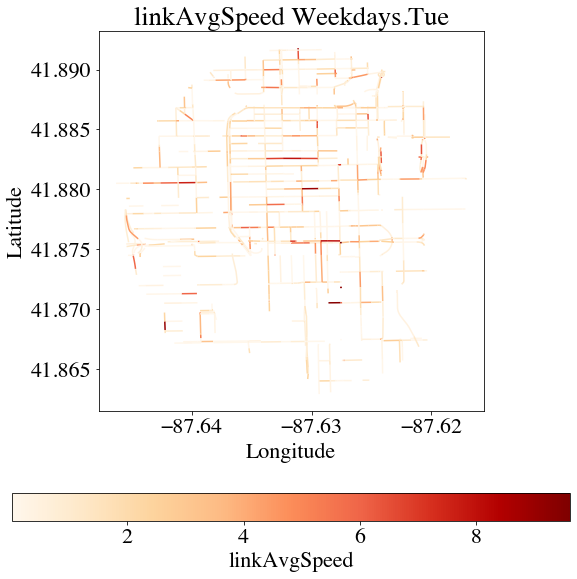

In [17]:
base_path = '/Users/shanyang/Downloads/ORNL-ML/Upload/Emissions Data/Traffic Volumes/Link Volumes'
Tue = weekday_conjection(days_path,Weekdays.Tue,base_path)

In [18]:
Tue.describe()

,linkID,linkLength,linkVolume,linkAvgSpeed
count,2615.000000,1163.000000,1163.000000,1163.000000
mean,1307.000000,0.041146,9.871919,1.401330
std,755.029801,0.034248,19.217436,1.656427
min,0.000000,0.000005,0.041667,0.020833
25%,653.500000,0.010724,0.958333,0.186417
50%,1307.000000,0.035366,2.500000,0.773023
75%,1960.500000,0.064106,8.708333,2.026121
max,2614.000000,0.233220,185.958333,9.625003


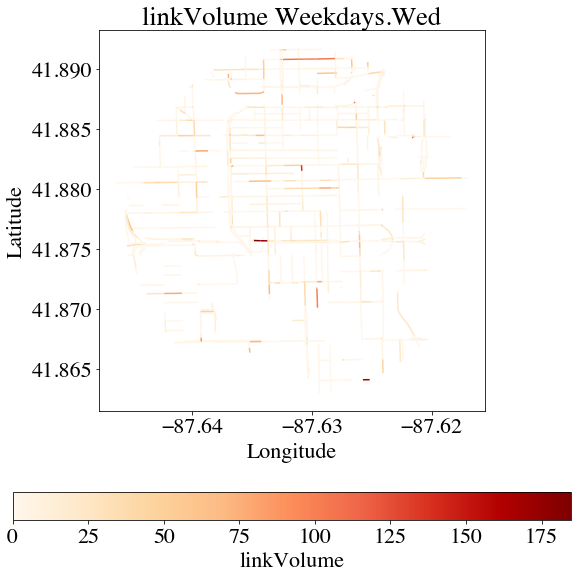

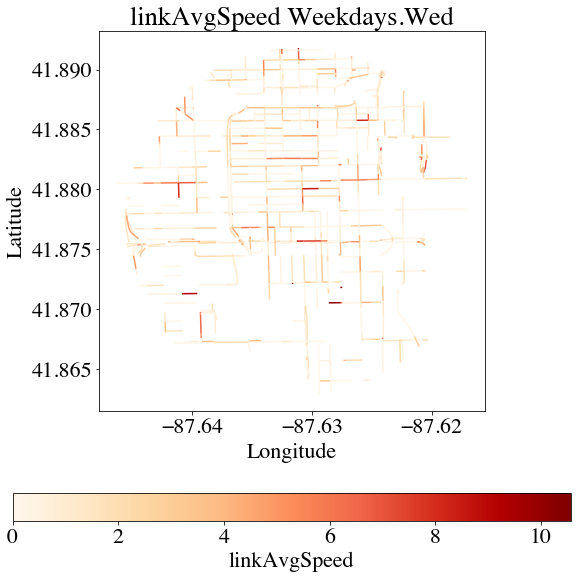

In [19]:
base_path = '/Users/shanyang/Downloads/ORNL-ML/Upload/Emissions Data/Traffic Volumes/Link Volumes'
Wed = weekday_conjection(days_path,Weekdays.Wed,base_path)

In [20]:
Wed.describe()

,linkID,linkLength,linkVolume,linkAvgSpeed
count,2615.000000,1157.000000,1157.000000,1157.000000
mean,1307.000000,0.041193,10.778954,1.465252
std,755.029801,0.034210,19.683609,1.705421
min,0.000000,0.000005,0.000000,0.000000
25%,653.500000,0.010785,0.958333,0.185268
50%,1307.000000,0.035731,2.833333,0.830417
75%,1960.500000,0.064343,10.750000,2.098865
max,2614.000000,0.233220,184.625000,10.564377


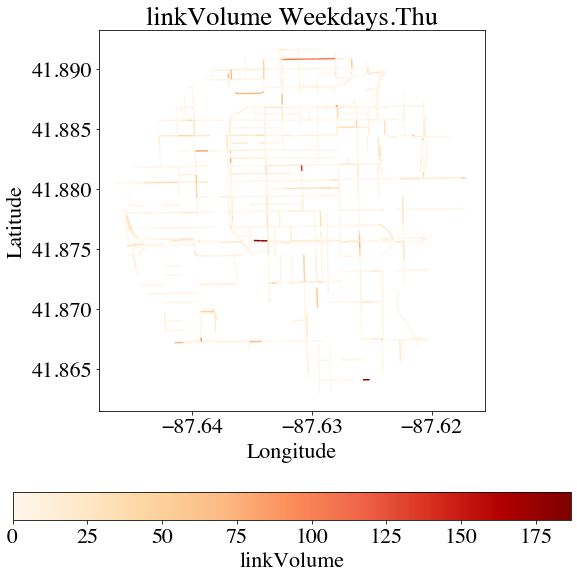

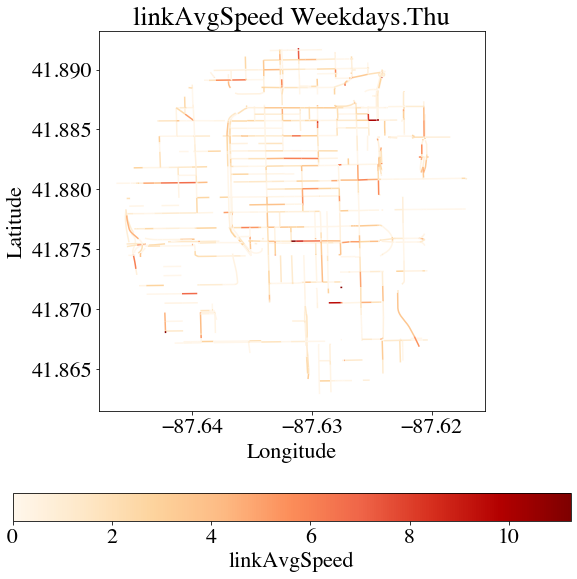

In [21]:
base_path = '/Users/shanyang/Downloads/ORNL-ML/Upload/Emissions Data/Traffic Volumes/Link Volumes'
Thu = weekday_conjection(days_path,Weekdays.Thu,base_path)

In [22]:
Thu.describe()

,linkID,linkLength,linkVolume,linkAvgSpeed
count,2615.000000,1161.000000,1161.000000,1161.000000
mean,1307.000000,0.041189,9.162109,1.429529
std,755.029801,0.034261,17.680522,1.720814
min,0.000000,0.000005,0.000000,0.000000
25%,653.500000,0.010738,0.958333,0.182097
50%,1307.000000,0.035661,2.500000,0.730636
75%,1960.500000,0.064343,8.541667,2.106171
max,2614.000000,0.233220,186.625000,11.249911


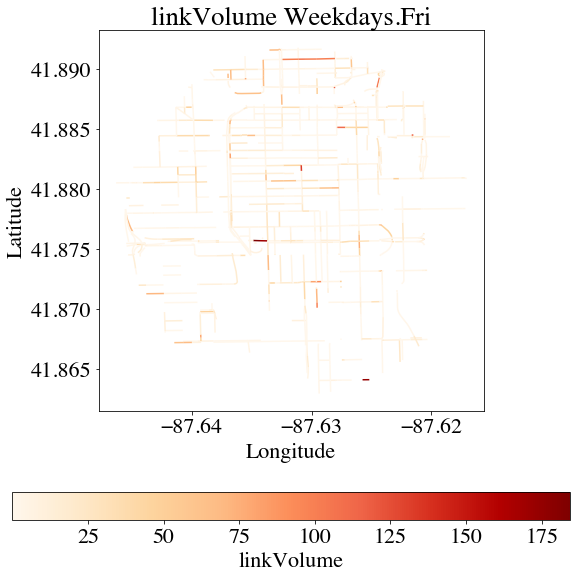

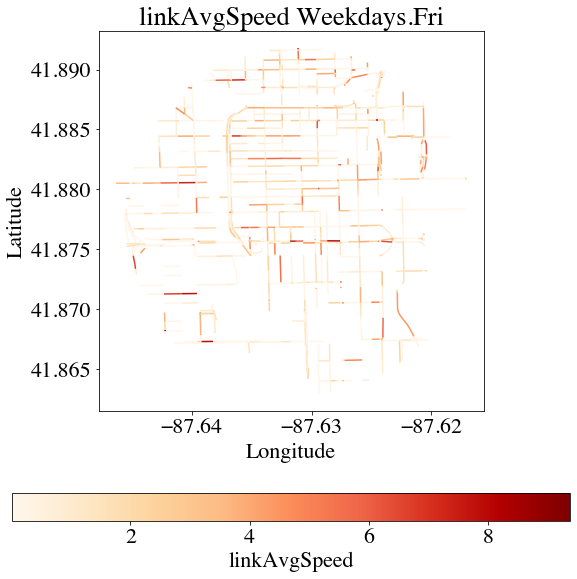

In [23]:
base_path = '/Users/shanyang/Downloads/ORNL-ML/Upload/Emissions Data/Traffic Volumes/Link Volumes'
Fri = weekday_conjection(days_path,Weekdays.Fri,base_path)

In [24]:
Mon.describe()

,linkID,linkLength,linkVolume,linkAvgSpeed
count,2615.000000,1161.000000,1161.000000,1161.000000
mean,1307.000000,0.041153,10.473407,1.461235
std,755.029801,0.034201,19.469332,1.701523
min,0.000000,0.000005,0.041667,0.020833
25%,653.500000,0.010738,1.000000,0.186417
50%,1307.000000,0.035661,2.708333,0.785000
75%,1960.500000,0.064343,10.458333,2.215286
max,2614.000000,0.233220,185.375000,9.225834


In [25]:
Tue.describe()

,linkID,linkLength,linkVolume,linkAvgSpeed
count,2615.000000,1163.000000,1163.000000,1163.000000
mean,1307.000000,0.041146,9.871919,1.401330
std,755.029801,0.034248,19.217436,1.656427
min,0.000000,0.000005,0.041667,0.020833
25%,653.500000,0.010724,0.958333,0.186417
50%,1307.000000,0.035366,2.500000,0.773023
75%,1960.500000,0.064106,8.708333,2.026121
max,2614.000000,0.233220,185.958333,9.625003


In [26]:
Wed.describe()

,linkID,linkLength,linkVolume,linkAvgSpeed
count,2615.000000,1157.000000,1157.000000,1157.000000
mean,1307.000000,0.041193,10.778954,1.465252
std,755.029801,0.034210,19.683609,1.705421
min,0.000000,0.000005,0.000000,0.000000
25%,653.500000,0.010785,0.958333,0.185268
50%,1307.000000,0.035731,2.833333,0.830417
75%,1960.500000,0.064343,10.750000,2.098865
max,2614.000000,0.233220,184.625000,10.564377


In [27]:
Thu.describe()

,linkID,linkLength,linkVolume,linkAvgSpeed
count,2615.000000,1161.000000,1161.000000,1161.000000
mean,1307.000000,0.041189,9.162109,1.429529
std,755.029801,0.034261,17.680522,1.720814
min,0.000000,0.000005,0.000000,0.000000
25%,653.500000,0.010738,0.958333,0.182097
50%,1307.000000,0.035661,2.500000,0.730636
75%,1960.500000,0.064343,8.541667,2.106171
max,2614.000000,0.233220,186.625000,11.249911


In [28]:
Fri.describe()

,linkID,linkLength,linkVolume,linkAvgSpeed
count,2615.000000,1162.000000,1162.000000,1162.000000
mean,1307.000000,0.041220,10.985800,1.454524
std,755.029801,0.034262,20.027245,1.650169
min,0.000000,0.000005,0.041667,0.020833
25%,653.500000,0.010750,0.916667,0.186417
50%,1307.000000,0.035696,2.708333,0.801180
75%,1960.500000,0.064386,11.145833,2.173905
max,2614.000000,0.233220,184.458333,9.378585


## Analyse the chaning of linkVolume through out a single day
The number of cars on the road increase drastically from 4am to 7am, when the daily commutation happens. The number of cars on the road are almost constant through out the day. From 15pm to 23pm the number of cars decrease gradually. Finally the number of cars on the road drop from 23pm to 24pm. The busiest line through out the day are listed below as well. 

In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'Times','weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)

In [2]:
time_path_base = '/Users/shanyang/Downloads/ORNL-ML/Upload/Vehicle Data/Simulation Snapshot';
time_dirs = os.listdir(time_path_base)
time = pd.DataFrame()
for name in time_dirs:
    time_path = os.path.join(time_path_base, name)
    temp = pd.read_csv(time_path, usecols=['LINK','TIME','VEHICLE'])
    time = time.append(temp)

In [3]:
def parsedate(x):
    def a(x):
        date =  pd.to_datetime(x, format = '%H:%M:%S')
        return date

    def b(x):
        date =pd.to_datetime(x, format = '%H:%M')
        return date

    def c(x):
        date = pd.to_datetime(x, format = '1@%H:%M:%S')
        return date

    def d(x):
        dateparse = pd.to_datetime(x, format = '1@%H:%M')
        return date
    for fun in [a, b, c, d]:
        try:
            date = fun(x)
            return date
        except:
            pass

In [4]:
time = time.rename(columns={'LINK':'linkID'})
time.head()

,VEHICLE,TIME,linkID
0,94730,11:07,2253
1,193299,11:07,1868
2,79690,11:07,2252
3,191799,11:07,116
4,133102,11:07,1096


In [5]:
time['TIME']= time['TIME'].apply(parsedate).dt.time

In [6]:
time.head()

,VEHICLE,TIME,linkID
0,94730,11:07:00,2253
1,193299,11:07:00,1868
2,79690,11:07:00,2252
3,191799,11:07:00,116
4,133102,11:07:00,1096


In [7]:
time.to_csv('all_times.csv', index=False)

save the time data as check point

In [18]:
time.to_csv('all_times_dropna.csv',index=False)

data processing

In [29]:
time = pd.read_csv('all_times_dropna.csv')

In [30]:
time['HOUR']=pd.to_datetime(time['TIME']).dt.hour

In [33]:
time.dropna(inplace = True)
time.head()
print(time.shape)

(24275506, 4)


In [34]:
time.head()

,VEHICLE,TIME,linkID,HOUR
0,94730,11:07:00,2253,11
1,193299,11:07:00,1868,11
2,79690,11:07:00,2252,11
3,191799,11:07:00,116,11
4,133102,11:07:00,1096,11


In [35]:
peak_time = time.groupby(['HOUR']).count()

In [36]:
peak_time.head()

,VEHICLE,TIME,linkID
HOUR,,,
0,571071,571071,571071
2,51,51,51
3,5854,5854,5854
4,84687,84687,84687
5,471811,471811,471811


In [37]:
peak_time=peak_time.rename(index={0: 24})

In [38]:
peak_time.head()

,VEHICLE,TIME,linkID
HOUR,,,
24,571071,571071,571071
2,51,51,51
3,5854,5854,5854
4,84687,84687,84687
5,471811,471811,471811


In [39]:
peak_time = peak_time.sort_index()

Text(0.5, 1.0, 'Number of cars on the road')

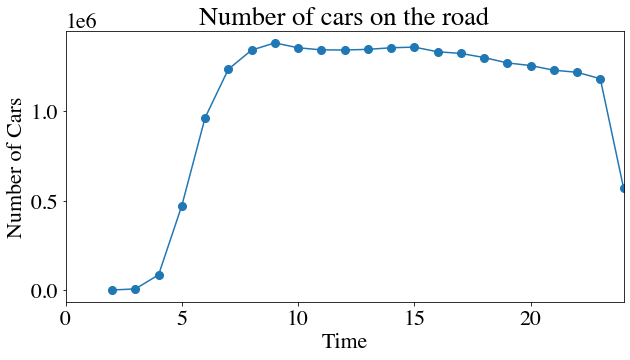

In [255]:
fig, ax = plt.subplots(figsize=(10,5))
peak_time['linkID'].plot(ax= ax,marker='o', markersize=8, linestyle='-', label="Cars on the Road")
ax.set_xlim(0,24)
ax.set_xlabel('Time')
ax.set_ylabel('Number of Cars')
ax.set_title('Number of cars on the road')

## The busiest line through out the day

In [42]:
lines=time.groupby('linkID').count()
lines.sort_values(by='VEHICLE', inplace = True, ascending=False)

In [257]:
lines.head(15).index

Int64Index([157, 1440, 1698, 2213, 1107, 2129, 218, 791, 2210, 58, 857, 63,
            858, 965, 2158],
           dtype='int64', name='linkID')

## Data visualization of pollution

In [164]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'Times','weight' : 'bold','size'   : 22}
matplotlib.rc('font', **font)

In [44]:
chicago = load_chicago('/Users/shanyang/Downloads/ORNL-ML/Upload/Road Network')
chicago.head()

,FROM,TO,FCC,geometry,linkID
0,0,1,A50,"LINESTRING (-87.62436 41.87701, -87.62451 41.8...",0
1,1,2,A50,"LINESTRING (-87.62451 41.87700, -87.62523 41.8...",1
2,2,3,A50,"LINESTRING (-87.62523 41.87698, -87.62605 41.8...",2
3,3,4,A50,"LINESTRING (-87.62605 41.87695, -87.62634 41.8...",3
4,4,5,A50,"LINESTRING (-87.62634 41.87696, -87.62654 41.8...",4


Emission data on Monday 

In [45]:
emission_path_base = '/Users/shanyang/Downloads/ORNL-ML/Upload/Emissions Data/Emissions';
emission_dirs = []
for i in range(24):
    emission_dirs.append('2017-07-04_'+str(i).zfill(2)+'_energy.csv')

In [46]:
emission = pd.DataFrame()
for name in emission_dirs:
    emission_path = os.path.join(emission_path_base, name)
    temp = pd.read_csv(emission_path, usecols=['linkID','hour','emquant'])
    emission = emission.append(temp)

In [47]:
emission.head()

,hour,linkID,emquant
0,0,2,0.0
1,0,3,0.0
2,0,4,0.0
3,0,5,0.0
4,0,7,0.0


In [48]:
emission_byID = emission.groupby(['linkID'])['emquant'].agg('sum')

In [49]:
emission_byID.head()

linkID
2    276028.871033
3    288501.989051
4     99246.567451
5     68116.502720
7     55971.549922
Name: emquant, dtype: float64

In [50]:
chicago_emission=chicago.join(emission_byID, rsuffix = '_', how = 'left',on='linkID').fillna(0)

In [51]:
chicago_emission.head()

,FROM,TO,FCC,geometry,linkID,emquant
0,0,1,A50,"LINESTRING (-87.62436 41.87701, -87.62451 41.8...",0,0.000000
1,1,2,A50,"LINESTRING (-87.62451 41.87700, -87.62523 41.8...",1,0.000000
2,2,3,A50,"LINESTRING (-87.62523 41.87698, -87.62605 41.8...",2,276028.871033
3,3,4,A50,"LINESTRING (-87.62605 41.87695, -87.62634 41.8...",3,288501.989051
4,4,5,A50,"LINESTRING (-87.62634 41.87696, -87.62654 41.8...",4,99246.567451


Text(0.5, 1.0, 'Emquant on Monday 2017-07-04')

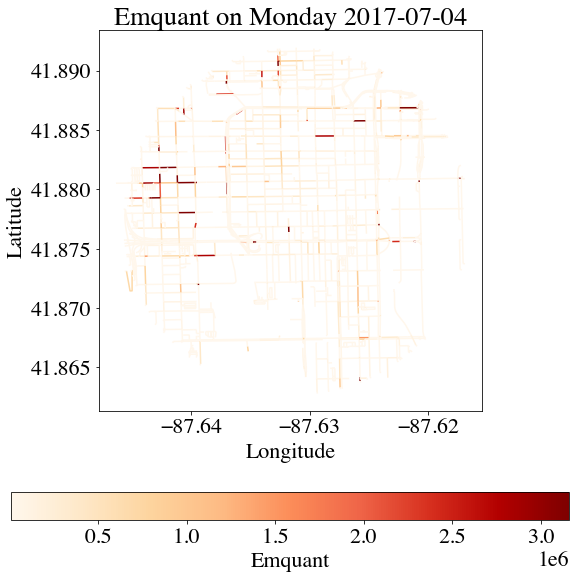

In [52]:
fig,ax = plt.subplots(figsize = (10,10))
ax = chicago_emission.plot(column = 'emquant',
                  cmap = 'OrRd',
                  vmin = 10**4,
                  vmax = 10**6.5,
                  legend = True,
                  legend_kwds={'label':'Emquant','orientation': 'horizontal'},
                  ax = ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f"Emquant on Monday 2017-07-04")

### Visualization the relations between the speed, linkVolume, linkLength and Emquant on Monday as an example

In [53]:
dataset_mon = pd.concat([Mon[{'linkVolume','linkAvgSpeed','linkLength'}],chicago_emission['emquant']], axis =1)

In [54]:
dataset_mon.head()

,linkAvgSpeed,linkVolume,linkLength,emquant
0,2.340343,6.458333,0.037455,0.000000
1,3.326249,5.958333,0.042273,0.000000
2,3.617016,5.541667,0.014927,276028.871033
3,3.898066,5.291667,0.010361,288501.989051
4,3.974726,5.166667,0.008573,99246.567451


In [55]:
dataset_mon.dropna(inplace = True)

In [66]:
dataset_mon.shape[0]

1161

### Visialize relations between pairs of data: linkAvgSpeed, linkVolume, linkLength, emquant

Text(0, 0.5, 'linkVolume')

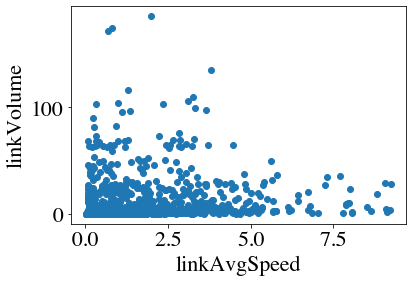

In [57]:
fig, ax = plt.subplots()
ax.scatter(dataset_mon.loc[:,'linkAvgSpeed'].values,dataset_mon.loc[:,'linkVolume'].values)
ax.set_xlabel('linkAvgSpeed')
ax.set_ylabel('linkVolume')

Text(0, 0.5, 'linkLength')

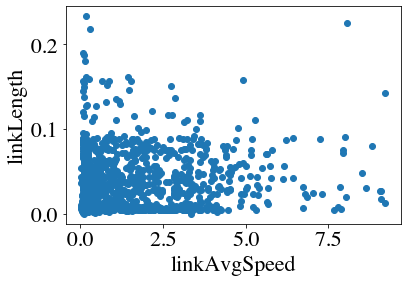

In [58]:
fig, ax = plt.subplots()
ax.scatter(dataset_mon.loc[:,'linkAvgSpeed'].values,dataset_mon.loc[:,'linkLength'].values)
ax.set_xlabel('linkAvgSpeed')
ax.set_ylabel('linkLength')

Text(0, 0.5, 'linkLength')

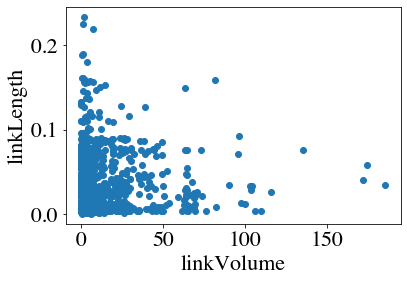

In [59]:
fig, ax = plt.subplots()
ax.scatter(dataset_mon.loc[:,'linkVolume'].values,dataset_mon.loc[:,'linkLength'].values)
ax.set_xlabel('linkVolume')
ax.set_ylabel('linkLength')

Text(0, 0.5, 'emquant')

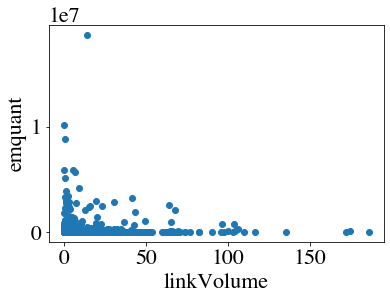

In [60]:
fig, ax = plt.subplots()
ax.scatter(dataset_mon.loc[:,'linkVolume'].values,dataset_mon.loc[:,'emquant'].values)
ax.set_xlabel('linkVolume')
ax.set_ylabel('emquant')

Text(0, 0.5, 'emquant')

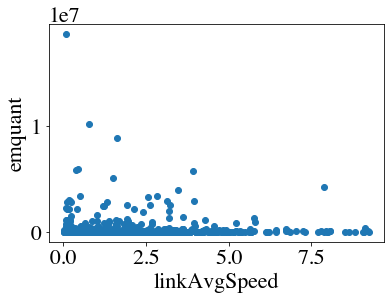

In [61]:
fig, ax = plt.subplots()
ax.scatter(dataset_mon.loc[:,'linkAvgSpeed'].values,dataset_mon.loc[:,'emquant'].values)
ax.set_xlabel('linkAvgSpeed')
ax.set_ylabel('emquant')

Text(0, 0.5, 'emquant')

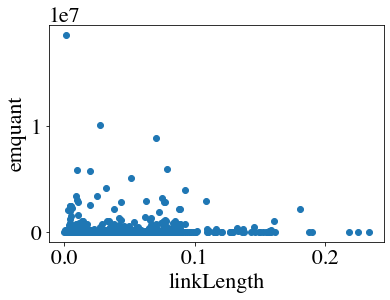

In [62]:
fig, ax = plt.subplots()
ax.scatter(dataset_mon.loc[:,'linkLength'].values,dataset_mon.loc[:,'emquant'].values)
ax.set_xlabel('linkLength')
ax.set_ylabel('emquant')

### Built a dataset with linkAvgSpeed, linkVolume, linkLength, emquant to do outlier detection. 
In addition, to understand where high emquants, linkAvgSpeed and linkVolume are suspecious and need to be explained with furthure informations.

In [121]:
X = dataset_mon.iloc[:,[0,1,2]].values

In [122]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_z = MinMaxScaler()

In [123]:
X = dataset_mon.iloc[:,[0,1,2]].values
X[:,0]=scaler_x.fit_transform(X[:,0].reshape(-1, 1)).reshape(1,-1)
X[:,1]=scaler_y.fit_transform(X[:,1].reshape(-1, 1)).reshape(1,-1)
X[:,2]=scaler_z.fit_transform(X[:,2].reshape(-1, 1)).reshape(1,-1)

Text(0.5, 0, 'linkLength')

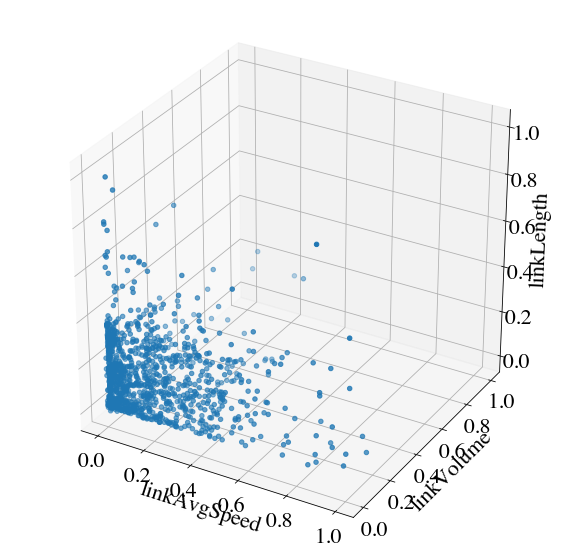

In [141]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2])
ax.set_xlabel('linkAvgSpeed')
ax.set_ylabel('linkVolume')
ax.set_zlabel('linkLength')

In [71]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [213]:
# Example settings
length = dataset_mon.shape[0]
n_samples = dataset_mon.shape[0]
outliers_fraction = 0.02
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [214]:
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=100, contamination=outliers_fraction))]

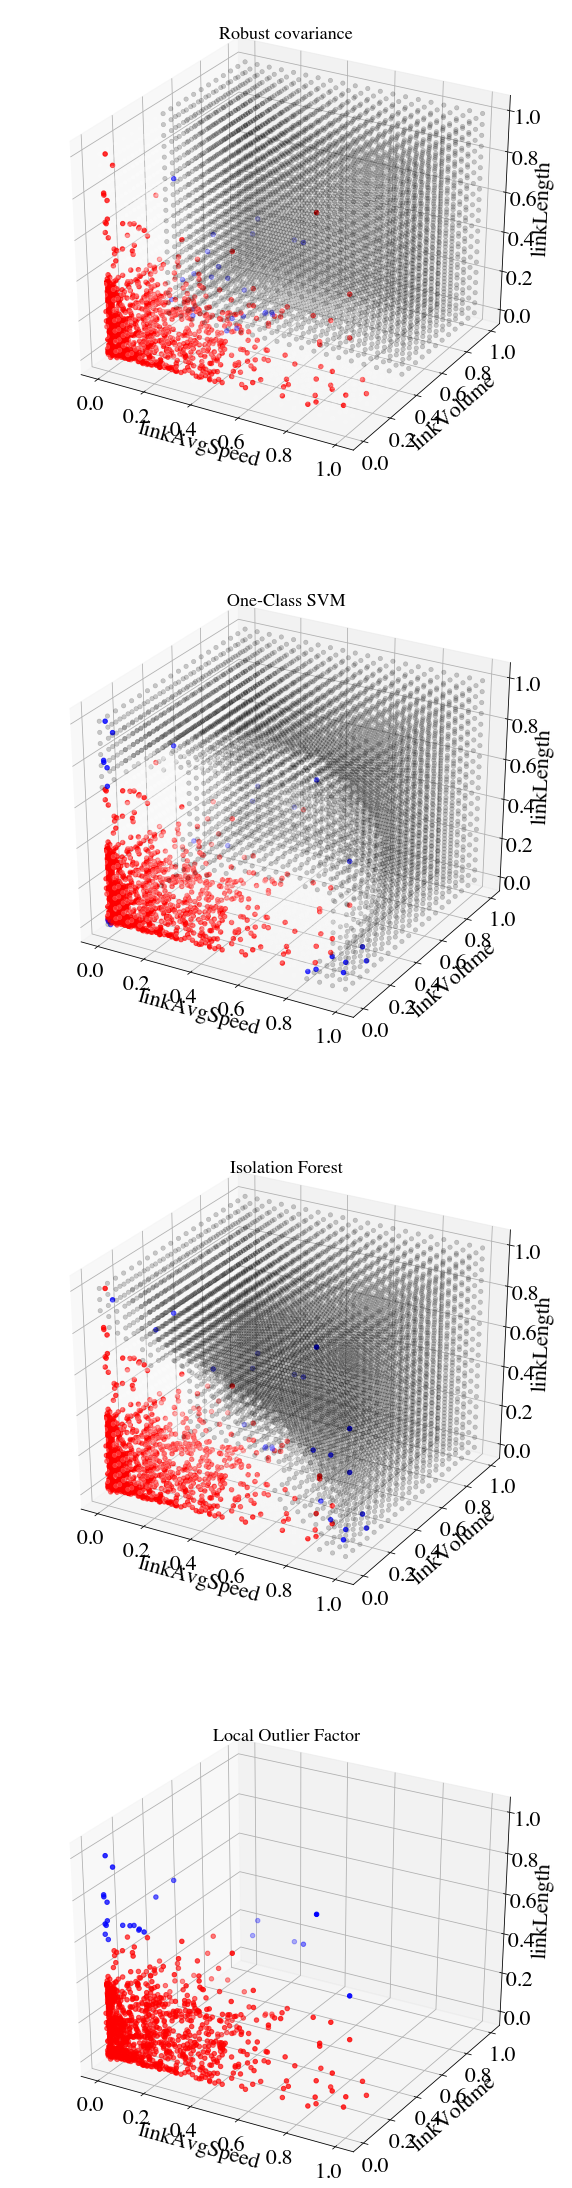

In [215]:
xx, yy, zz = np.meshgrid(np.linspace(0, 1,20), np.linspace(0, 1, 20),np.linspace(0, 1, 20))
mask=[]
fig = plt.figure(figsize=(10,40))
index = len(anomaly_algorithms)*100+10+1;
for name, algorithm in anomaly_algorithms:
    if name == "Local Outlier Factor":
        y_pred = algorithm.fit_predict(X)
        mask.append(y_pred==-1)
    else:
        y_pred = algorithm.fit(X).predict(X)
        mask.append(y_pred==-1)
        
    if name != "Local Outlier Factor":
        predict = algorithm.predict(np.c_[xx.ravel(),yy.ravel(),zz.ravel()])
        predict = predict.reshape(xx.shape)
        ax = fig.add_subplot(index, projection='3d')
        ax.scatter(X[:,0],X[:,1],X[:,2],c= y_pred, cmap ='bwr')
        ax.scatter(xx,yy,zz, c= predict,cmap='gist_gray', linewidth=0.5,alpha = 0.2)
        ax.set_xlabel('linkAvgSpeed')
        ax.set_ylabel('linkVolume')
        ax.set_zlabel('linkLength')
        plt.title(name, size=18)
    else:
        ax = fig.add_subplot(index, projection='3d')
        ax.scatter(X[:,0],X[:,1],X[:,2],c= y_pred, cmap ='bwr')
        ax.set_xlabel('linkAvgSpeed')
        ax.set_ylabel('linkVolume')
        ax.set_zlabel('linkLength')
        plt.title("Local Outlier Factor", size=18)
    index +=1

### Find the linID of the outliers 
Based on the anomaly detection algorithms the links with extrame low speed and high linkVolumes are:
[110, 111, 112, 475]. These are the traffice hot spots where the congestion happens. 

### "Robust covariance" is not a reasonable anomaly detection algorithme for this dataset

#### Based on oneclass SVM
The places with low linkAverageSpeed and high linkVolumes are the places where the conjection happens (linkID): 
[110, 111, 112, 409, 410, 475]

In [277]:
outliers=(dataset_mon[mask[1]]['linkAvgSpeed'] < 2.5) & (dataset_mon[mask[1]]['linkVolume'] > 50)
outliers[outliers==True].index

Int64Index([110, 111, 112, 409, 410, 475], dtype='int64')

Text(0, 0.5, 'linkLength')

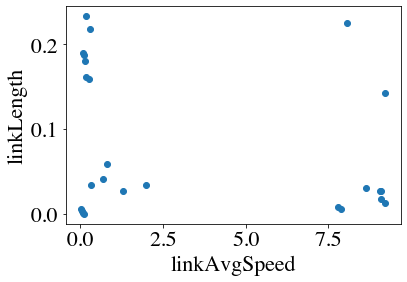

In [265]:
fig, ax = plt.subplots()
ax.scatter(dataset_mon[mask[1]]['linkAvgSpeed'].values,dataset_mon[mask[1]]['linkLength'].values)
ax.set_xlabel('linkAvgSpeed')
ax.set_ylabel('linkLength')

Text(0, 0.5, 'linkVolume')

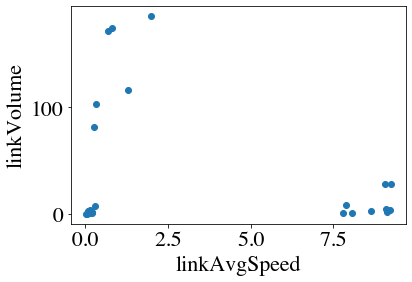

In [266]:
fig, ax = plt.subplots()
ax.scatter(dataset_mon[mask[1]]['linkAvgSpeed'].values,dataset_mon[mask[1]]['linkVolume'].values)
ax.set_xlabel('linkAvgSpeed')
ax.set_ylabel('linkVolume')

#### Based on Isolation Forest
The places with low linkAverageSpeed and high linkVolumes are the places where the conjection happens (linkID): 
[110, 111, 112, 475]

In [278]:
outliers=(dataset_mon[mask[2]]['linkAvgSpeed'] < 2.5) & (dataset_mon[mask[1]]['linkVolume'] > 50)
outliers[outliers==True].index

Int64Index([110, 111, 112, 475], dtype='int64')

In [217]:
dataset_mon[mask[2]]

,linkAvgSpeed,linkVolume,linkLength,emquant
48,9.095770,4.708333,0.026925,0.000000
110,0.809926,174.208333,0.058856,176710.237613
111,0.671798,171.583333,0.041147,0.000000
112,1.992947,185.375000,0.034615,0.000000
113,3.785075,135.375000,0.076290,0.000000
226,7.311949,35.083333,0.023795,0.000000
227,7.685694,35.166667,0.004743,35989.942723
342,9.105698,1.416667,0.017470,405750.748956
416,9.060271,28.583333,0.027525,0.000000
442,9.221895,3.583333,0.143140,57001.859487


#### Based on Local Outlier Factor
The places with low linkAverageSpeed and high linkVolumes are the places where the conjection happens (linkID): 

[110, 111, 112,475]

In [280]:
outliers=(dataset_mon[mask[3]]['linkAvgSpeed'] < 2.5) & (dataset_mon[mask[1]]['linkVolume'] > 50)
outliers[outliers==True].index

Int64Index([110, 111, 112, 475], dtype='int64')

In [218]:
dataset_mon[mask[3]]

,linkAvgSpeed,linkVolume,linkLength,emquant
110,0.809926,174.208333,0.058856,1.767102e+05
111,0.671798,171.583333,0.041147,0.000000e+00
112,1.992947,185.375000,0.034615,0.000000e+00
113,3.785075,135.375000,0.076290,0.000000e+00
237,0.867340,7.458333,0.156741,0.000000e+00
442,9.221895,3.583333,0.143140,5.700186e+04
453,0.104167,0.875000,0.187825,3.042212e+04
475,0.249366,81.875000,0.158729,0.000000e+00
484,1.518638,4.166667,0.156438,0.000000e+00
522,0.654804,5.250000,0.157057,0.000000e+00


## Anomaly detection for linkVolume linkLength and Emquant

### "Robust covariance" is not a reasonable anomaly detection algorithme for this dataset

In [281]:
dataset_mon_emq = dataset_mon[dataset_mon['emquant'] != 0]
dataset_mon_emq.head()

,linkAvgSpeed,linkVolume,linkLength,emquant
2,3.617016,5.541667,0.014927,276028.871033
3,3.898066,5.291667,0.010361,288501.989051
4,3.974726,5.166667,0.008573,99246.567451
5,3.284698,5.041667,0.037556,68116.502720
7,0.104167,0.833333,0.027489,55971.549922


In [282]:
X = dataset_mon.iloc[:,[1,2,3]].values

In [283]:
from sklearn.preprocessing import MinMaxScaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_z = MinMaxScaler()

In [284]:
X = dataset_mon.iloc[:,[0,1,2]].values
X[:,0]=scaler_x.fit_transform(X[:,0].reshape(-1, 1)).reshape(1,-1)
X[:,1]=scaler_y.fit_transform(X[:,1].reshape(-1, 1)).reshape(1,-1)
X[:,2]=scaler_z.fit_transform(X[:,2].reshape(-1, 1)).reshape(1,-1)

Text(0.5, 0, 'Emquant')

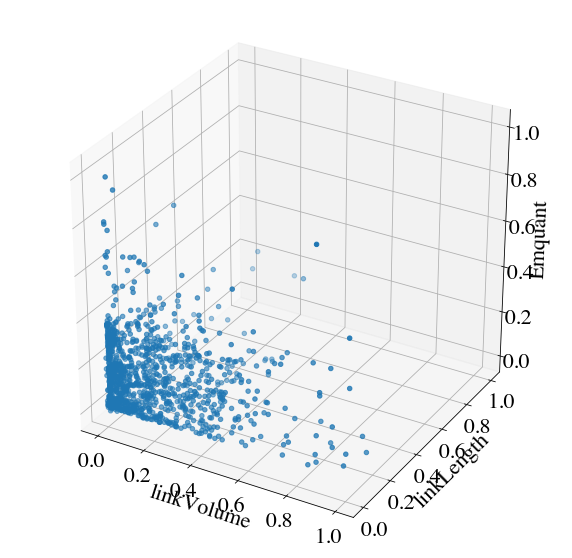

In [285]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2])
ax.set_xlabel('linkVolume')
ax.set_ylabel('linkLength')
ax.set_zlabel('Emquant')

In [286]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [287]:
# Example settings
length = dataset_mon.shape[0]
n_samples = dataset_mon.shape[0]
outliers_fraction = 0.02
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

In [288]:
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    ("Isolation Forest", IsolationForest(contamination=outliers_fraction,random_state=42)),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=100, contamination=outliers_fraction))]

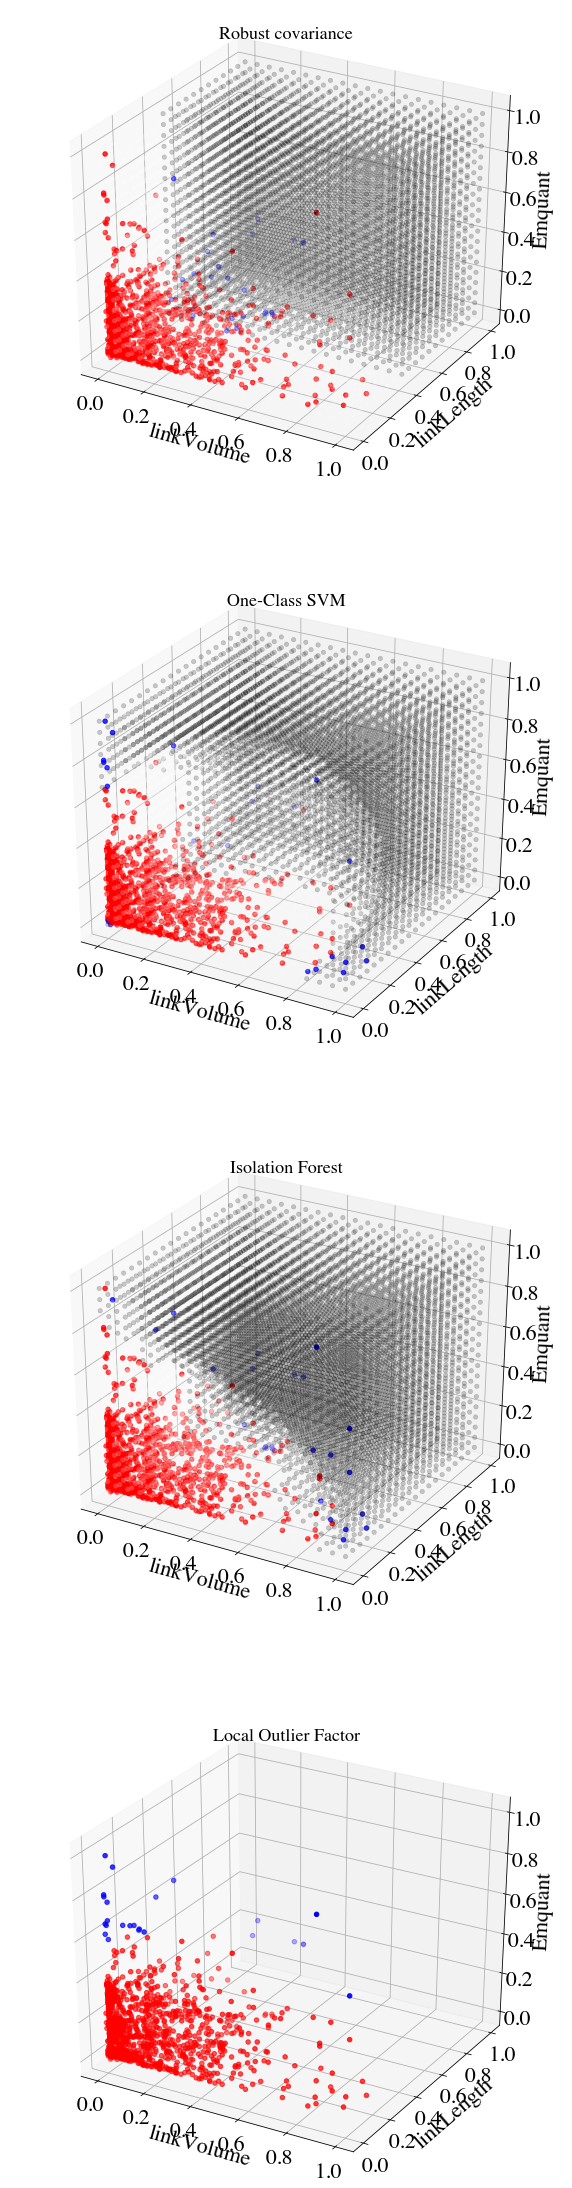

In [289]:
xx, yy, zz = np.meshgrid(np.linspace(0, 1,20), np.linspace(0, 1, 20),np.linspace(0, 1, 20))
mask=[]
fig = plt.figure(figsize=(10,40))
index = len(anomaly_algorithms)*100+10+1;
for name, algorithm in anomaly_algorithms:
    if name == "Local Outlier Factor":
        y_pred = algorithm.fit_predict(X)
        mask.append(y_pred==-1)
    else:
        y_pred = algorithm.fit(X).predict(X)
        mask.append(y_pred==-1)
        
    if name != "Local Outlier Factor":
        predict = algorithm.predict(np.c_[xx.ravel(),yy.ravel(),zz.ravel()])
        predict = predict.reshape(xx.shape)
        ax = fig.add_subplot(index, projection='3d')
        ax.scatter(X[:,0],X[:,1],X[:,2],c= y_pred, cmap ='bwr')
        ax.scatter(xx,yy,zz, c= predict,cmap='gist_gray', linewidth=0.5,alpha = 0.2)
        ax.set_xlabel('linkVolume')
        ax.set_ylabel('linkLength')
        ax.set_zlabel('Emquant')
        plt.title(name, size=18)
    else:
        ax = fig.add_subplot(index, projection='3d')
        ax.scatter(X[:,0],X[:,1],X[:,2],c= y_pred, cmap ='bwr')
        ax.set_xlabel('linkVolume')
        ax.set_ylabel('linkLength')
        ax.set_zlabel('Emquant')
        plt.title("Local Outlier Factor", size=18)
    index +=1

### Find the linID of the outliers 
LinkID 819 and 981 have extrame high emquant, which can not be explained by linkVolume and linkLength. Thus, further information relatvion to the building types are needed to under stand the high emquant values

In [290]:
dataset_mon[mask[1] & (dataset_mon['emquant'] != 0)].sort_index()

,linkAvgSpeed,linkVolume,linkLength,emquant
110,0.809926,174.208333,0.058856,1.767102e+05
342,9.105698,1.416667,0.017470,4.057507e+05
343,7.785925,1.000000,0.007859,9.217141e+04
409,0.315943,102.708333,0.033848,7.516476e+02
442,9.221895,3.583333,0.143140,5.700186e+04
453,0.104167,0.875000,0.187825,3.042212e+04
667,8.074444,1.083333,0.225088,5.914695e+04
819,0.184804,1.375000,0.161153,1.008822e+06
981,0.134732,3.458333,0.180413,2.172807e+06


Text(0.5, 0, 'linkLength')

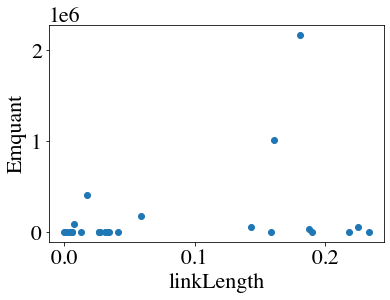

In [292]:
fig, ax = plt.subplots()
ax.scatter(dataset_mon[mask[1]]['linkLength'].values,dataset_mon[mask[1]]['emquant'].values)
ax.set_ylabel('Emquant')
ax.set_xlabel('linkLength')

Text(0.5, 0, 'linkVolume')

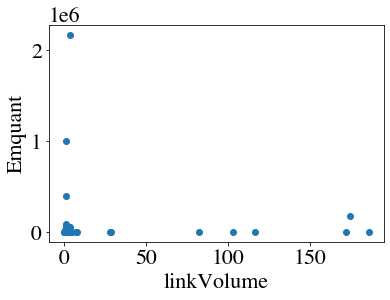

In [293]:
fig, ax = plt.subplots()
ax.scatter(dataset_mon[mask[1]]['linkVolume'].values,dataset_mon[mask[1]]['emquant'].values)
ax.set_ylabel('Emquant')
ax.set_xlabel('linkVolume')

In [294]:
dataset_mon[mask[1] & (dataset_mon['emquant'] > 10**6)]

,linkAvgSpeed,linkVolume,linkLength,emquant
819,0.184804,1.375000,0.161153,1.008822e+06
981,0.134732,3.458333,0.180413,2.172807e+06


In [242]:
dataset_mon[mask[2] & (dataset_mon['emquant'] != 0)].sort_index()

,linkAvgSpeed,linkVolume,linkLength,emquant
110,0.809926,174.208333,0.058856,176710.237613
227,7.685694,35.166667,0.004743,35989.942723
342,9.105698,1.416667,0.017470,405750.748956
442,9.221895,3.583333,0.143140,57001.859487
493,1.334532,96.375000,0.092411,774196.559257
494,2.343319,103.333333,0.029061,773184.838209
495,3.306709,99.625000,0.012019,155275.438314
496,3.636602,97.541667,0.013451,51244.635504
667,8.074444,1.083333,0.225088,59146.951441
1008,7.242024,26.875000,0.088022,86147.654295


In [296]:
dataset_mon[mask[2] & (dataset_mon['emquant'] > 10**6)]

,linkAvgSpeed,linkVolume,linkLength,emquant


In [244]:
dataset_mon[mask[3] & (dataset_mon['emquant'] != 0)].sort_values('emquant', ascending = False).sort_index()

,linkAvgSpeed,linkVolume,linkLength,emquant
110,0.809926,174.208333,0.058856,1.767102e+05
442,9.221895,3.583333,0.143140,5.700186e+04
453,0.104167,0.875000,0.187825,3.042212e+04
535,0.104167,2.250000,0.154873,2.852754e+04
667,8.074444,1.083333,0.225088,5.914695e+04
816,0.083333,1.666667,0.156659,9.660332e+04
819,0.184804,1.375000,0.161153,1.008822e+06
833,0.163892,39.250000,0.126739,1.963941e+03
981,0.134732,3.458333,0.180413,2.172807e+06
982,0.083333,1.250000,0.145273,4.431922e+05


In [297]:
dataset_mon[mask[3] & (dataset_mon['emquant'] > 10**6)]

,linkAvgSpeed,linkVolume,linkLength,emquant
819,0.184804,1.375000,0.161153,1.008822e+06
981,0.134732,3.458333,0.180413,2.172807e+06
